# Series de tiempo y redes neuronales.

Hay varias maneras de usar redes neuronales para predecir series de tiempo. Nuestro objetivo será llegar a transfomers, pero iremos explorando las ideas poco a poco.

Lo que vamos a hacer aquí es redes neuronales "fully connected", pero si lo piensas bien, estamos usando la idea de las redes neuronales convolucionales. Quedará claro por qué a lo largo del video.

Seguiremos usando la serie de tiempo de las temperaturas.

In [14]:
import numpy as np
import pandas as pd
import fastai.tabular.all as ft
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

In [2]:
torch.cuda.set_device(1)

In [3]:
torch.cuda.current_device()

1

In [4]:
df = pd.read_csv("daily-min-temperatures.csv",index_col='Date',parse_dates=True)

<Axes: xlabel='Date'>

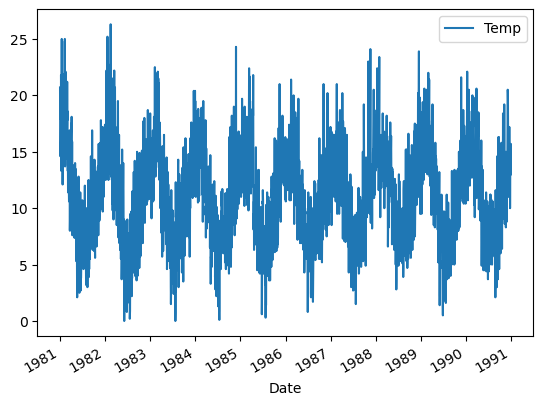

In [5]:
df.plot()

## ¿Cómo usar redes neuronales?

Hay muchas cosas que podemos hacer para usar redes neuronales en series de tiempo. Vamos a empezar por lo más más sencillo y poco a poco iremos agregando cosas. El plan será:

1. Que la red tome exclusivamente la temperatura del día anterior para predecir la temperatura del día siguiente.
2. Convolucionales: Agregarle las últimas $k$ temperaturas para que pueda hacer la predicción.
3. Agregarle información del mes y del año.
4. Agregarle por ejemplo la EWMA.
5. Agregarle la desviación estándar, y otra información.
6. ¿Por qué redes recurrentes?


### Cargando los datos

Recordemos que fastai puede cargar datos "tabulares" (e.g. un dataframe de pandas).

In [6]:
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


Queremos predecir la temperatura cada día basados en la temperatura anterior, así que debemos crear la columna "ultima_temp".

In [7]:
df['ultima_temp'] = df['Temp'].shift(1)

In [9]:
df = df.dropna()

In [10]:
df.head()

,Temp,ultima_temp
Date,,
1981-01-02,17.9,20.7
1981-01-03,18.8,17.9
1981-01-04,14.6,18.8
1981-01-05,15.8,14.6
1981-01-06,15.8,15.8


In [11]:
def error_l1(df,colA,colB):
    df = df.iloc[-365:]
    return np.mean(np.abs(df[colA]-df[colB]))
def error_rmse(df,colA,colB):
    df = df.iloc[-365:]
    return np.sqrt(np.mean(np.square(df[colA]-df[colB])))

In [12]:
error_l1(df,'Temp','ultima_temp')

2.024931506849315

In [13]:
error_rmse(df,'Temp','ultima_temp')

2.5824009217292243

In [48]:
alumnos = ["Miguel", "Paola", "Arnold", "Diego", "Gerardo", "Erika", "Hannia,", "Leo Grande", "Dani", "Leo chico"]

In [49]:
random.choice(alumnos)

'Erika'

In [24]:
def cargar_datos(df):
    n = len(df)
    v = n-365
    src = ft.TabularPandas(df,
                     cont_names = ['ultima_temp'],
                     y_names = ['Temp'],
                     splits = (list(range(v)),list(range(v,n)))
                          )
    return src.dataloaders(bs = 256)

In [26]:
dls = cargar_datos(df)

In [ ]:
def cargar_datos(df):
    X = ft.range_of(df)
    valid_cut = len(df) - 365
    src = ft.TabularPandas(df,
                       cont_names=list(df.columns[1:]),
                       y_names=['Temp'],
                       splits=(X[:valid_cut],X[valid_cut:]))
    return src.dataloaders(bs=1024)

In [ ]:
dls = cargar_datos(df)

In [39]:
x_cat, x_cont, y = dls.one_batch()

No se preocupen por el tensor vacío. Lo que ocurre es que fastai divide en datos categóricos y datos contínuos. Sin embargo, ahora no tenemos ningún dato categórico (luego tendremos), así que simplemente me da vacío en los categóricos. No usaremos eso por ahora.

In [40]:
def rmse_loss(yp,y):
    return torch.sqrt(F.mse_loss(yp,y))

In [41]:
learn=ft.tabular_learner(dls,layers=[],metrics=[F.l1_loss,rmse_loss])

In [42]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=1, out_features=1, bias=True)
    )
  )
)

SuggestedLRs(valley=0.0691830962896347)

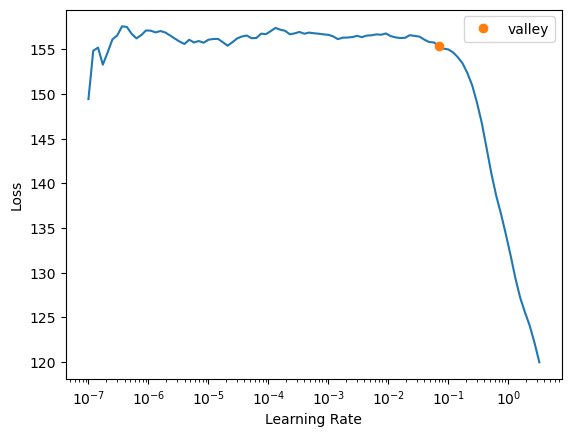

In [43]:
learn.lr_find()

In [44]:
learn.fit_one_cycle(50,1e-1)

epoch,train_loss,valid_loss,l1_loss,rmse_loss,time
0,155.105042,166.643677,12.315500,12.906453,00:00
1,153.991714,163.342010,12.198889,12.777955,00:00
2,152.490021,158.353439,12.025048,12.581318,00:00
3,149.144424,146.386810,11.599596,12.096618,00:00
4,142.461578,118.676903,10.519345,10.891856,00:00
5,128.694870,70.152512,7.987723,8.374830,00:00
6,107.364120,21.590105,3.953012,4.644118,00:00
7,83.253876,6.508121,2.020398,2.549207,00:00
8,65.061211,6.114482,1.948498,2.466245,00:00
9,51.352806,6.300318,1.999481,2.499870,00:00


Más o menos tiene el mismo error que la baseline (poquito mejor), lo cual es bueno! Vamos a ver si podemos hacerlo mejor con más capas.

In [45]:
learn=ft.tabular_learner(dls,layers=[128,128],metrics=[F.l1_loss,rmse_loss])

In [ ]:
learn.lr_find()

In [46]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=1, out_features=128, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=128, out_features=128, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [47]:
learn.fit_one_cycle(50,3e-2)

epoch,train_loss,valid_loss,l1_loss,rmse_loss,time
0,130.310486,103.440086,9.818756,10.168506,00:00
1,128.481125,114.751968,10.427028,10.710749,00:00
2,124.339394,109.826256,10.201099,10.478622,00:00
3,113.161743,60.203579,7.362174,7.757296,00:00
4,88.647591,5.927974,1.900360,2.424088,00:00
5,67.869774,15.139627,3.282373,3.890162,00:00
6,52.265091,7.785719,2.235300,2.777505,00:00
7,41.076916,6.974854,2.063859,2.626807,00:00
8,32.875786,6.446862,2.014771,2.522467,00:00
9,26.781366,6.664519,2.017286,2.577094,00:00


Un poquito mejor, pero... no mucho. Pues es que piénsenlo: nada más le dimos la temperatura anterior. Cómo le va a hacer para hacerlo mejor?

## Redes convolucionales.

Si en vez de darle la temperatura anterior le damos las $k$ anteriores, ¿podremos mejorarlo?

In [59]:
import random

In [60]:
df = pd.read_csv("daily-min-temperatures.csv",index_col='Date',parse_dates=True)

In [65]:
df

,Temp,temp_anterior1,temp_anterior2,temp_anterior3,temp_anterior4,temp_anterior5,temp_anterior6,temp_anterior7,temp_anterior8
Date,,,,,,,,,
1981-01-09,21.8,17.4,15.8,15.8,15.8,14.6,18.8,17.9,20.7
1981-01-10,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8,17.9
1981-01-11,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8
1981-01-12,13.3,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6
1981-01-13,16.7,13.3,16.2,20.0,21.8,17.4,15.8,15.8,15.8
...,...,...,...,...,...,...,...,...,...
1990-12-27,14.0,14.6,12.9,10.0,13.9,13.2,13.1,15.4,14.7
1990-12-28,13.6,14.0,14.6,12.9,10.0,13.9,13.2,13.1,15.4
1990-12-29,13.5,13.6,14.0,14.6,12.9,10.0,13.9,13.2,13.1


In [62]:
k = 8
for i in range(1,k+1) :
    df[f'temp_anterior{i}'] = df['Temp'].shift(i)

In [64]:
df = df.dropna()

In [66]:
random.choice(alumnos)

'Paola'

In [67]:
def cargar_datos(df):
    n = len(df)
    v = n-365
    src = ft.TabularPandas(df,
                     cont_names = [f'temp_anterior{i}' for i in range(1,k+1)],
                     y_names = ['Temp'],
                     splits = (list(range(v)),list(range(v,n)))
                          )
    return src.dataloaders(bs = 256)

In [102]:
random.choice(alumnos)

'Diego'

In [68]:
dls = cargar_datos(df)

In [85]:
learn=ft.tabular_learner(dls,
                         layers=[128],
                         opt_func=ft.ranger,
                         metrics=[F.l1_loss,rmse_loss])

In [83]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=8, out_features=128, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

SuggestedLRs(valley=0.04786301031708717)

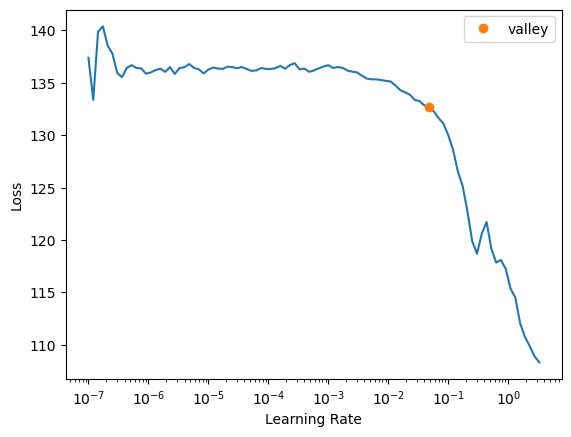

In [86]:
learn.lr_find()

In [87]:
learn.fit_one_cycle(50,7e-2,div=1,pct_start=0.7)

epoch,train_loss,valid_loss,l1_loss,rmse_loss,time
0,326.312622,186.106033,12.715884,13.637826,00:00
1,206.254745,85.183296,8.323979,9.215677,00:00
2,140.536545,28.503124,4.676866,5.311063,00:00
3,97.421280,9.911662,2.480084,3.129405,00:00
4,70.566223,9.455142,2.382361,3.072549,00:00
5,53.355740,7.513318,2.159838,2.738830,00:00
6,41.157024,5.523904,1.835294,2.346266,00:00
7,32.478874,5.463264,1.825858,2.331402,00:00
8,26.158495,5.322848,1.788802,2.298894,00:00
9,21.443640,5.298129,1.778770,2.293087,00:00


In [88]:
random.choice(alumnos)

'Gerardo'

In [90]:
df

,Temp,temp_anterior1,temp_anterior2,temp_anterior3,temp_anterior4,temp_anterior5,temp_anterior6,temp_anterior7,temp_anterior8
Date,,,,,,,,,
1981-01-09,21.8,17.4,15.8,15.8,15.8,14.6,18.8,17.9,20.7
1981-01-10,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8,17.9
1981-01-11,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8
1981-01-12,13.3,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6
1981-01-13,16.7,13.3,16.2,20.0,21.8,17.4,15.8,15.8,15.8
...,...,...,...,...,...,...,...,...,...
1990-12-27,14.0,14.6,12.9,10.0,13.9,13.2,13.1,15.4,14.7
1990-12-28,13.6,14.0,14.6,12.9,10.0,13.9,13.2,13.1,15.4
1990-12-29,13.5,13.6,14.0,14.6,12.9,10.0,13.9,13.2,13.1


In [94]:
fecha = df.index.year

In [95]:
fecha

Index([1981, 1981, 1981, 1981, 1981, 1981, 1981, 1981, 1981, 1981,
       ...
       1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990],
      dtype='int32', name='Date', length=3642)

In [98]:
df=df.copy()

In [100]:
df['año'] = df.index.year
df['mes'] = df.index.month
df['dia'] = df.index.day

In [101]:
df

,Temp,temp_anterior1,temp_anterior2,temp_anterior3,temp_anterior4,temp_anterior5,temp_anterior6,temp_anterior7,temp_anterior8,año,mes,dia
Date,,,,,,,,,,,,
1981-01-09,21.8,17.4,15.8,15.8,15.8,14.6,18.8,17.9,20.7,1981,1,9
1981-01-10,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8,17.9,1981,1,10
1981-01-11,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8,1981,1,11
1981-01-12,13.3,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6,1981,1,12
1981-01-13,16.7,13.3,16.2,20.0,21.8,17.4,15.8,15.8,15.8,1981,1,13
...,...,...,...,...,...,...,...,...,...,...,...,...
1990-12-27,14.0,14.6,12.9,10.0,13.9,13.2,13.1,15.4,14.7,1990,12,27
1990-12-28,13.6,14.0,14.6,12.9,10.0,13.9,13.2,13.1,15.4,1990,12,28
1990-12-29,13.5,13.6,14.0,14.6,12.9,10.0,13.9,13.2,13.1,1990,12,29


In [ ]:
k = 8
for i in range(1,k+1):
    df[f'ultima_{i}'] = df['Temp'].shift(i)

In [104]:
df['sin_mes'] = np.sin(2*np.pi*df['mes']/12)

In [105]:
df['cos_mes'] = np.cos(2*np.pi*df['mes']/12)

In [106]:
def cargar_datos(df):
    n = len(df)
    v = n-365
    src = ft.TabularPandas(df,
                     cont_names = [f'temp_anterior{i}' for i in range(1,k+1)]+['sin_mes','cos_mes','año'],
                     y_names = ['Temp'],
                     splits = (list(range(v)),list(range(v,n)))
                          )
    return src.dataloaders(bs = 256)

In [107]:
dls = cargar_datos(df)

In [108]:
learn=ft.tabular_learner(dls,
                         layers=[128],
                         opt_func=ft.ranger,
                         metrics=[F.l1_loss,rmse_loss])

In [109]:
learn.fit_one_cycle(50,3e-2,div=1,pct_start=0.7)

epoch,train_loss,valid_loss,l1_loss,rmse_loss,time
0,112.706360,54.031395,6.709165,7.342260,00:00
1,109.963524,127.211601,10.960186,11.270743,00:00
2,106.996529,119.929558,10.674061,10.941470,00:00
3,102.679329,94.874725,9.446123,9.723954,00:00
4,96.034386,75.139938,8.364963,8.654018,00:00
5,86.790840,57.814224,7.270252,7.597304,00:00
6,75.081451,36.400967,5.618319,6.029865,00:00
7,61.700073,17.294115,3.623919,4.154842,00:00
8,48.946133,6.529373,2.025028,2.539943,00:00
9,38.792282,5.206577,1.755854,2.274413,00:00


In [ ]:
df['Year'] = df.index.year.astype(float)
df['Month'] = df.index.month_name()
df['Day'] = df.index.day_of_year.astype(float)
df['ewma_0.1'] = df['ultima_1'].ewm(0.1).mean()
df['ewma_0.35'] = df['ultima_1'].ewm(0.35).mean()

In [ ]:
df.dropna(inplace=True)

In [ ]:
def cargar_datos(df):
    X = ft.range_of(df)
    valid_cut = len(df) - 365
    cat_names = ['Month']
    cont_names = [ c for c in df.columns[1:] if c not in cat_names]
    src = ft.TabularPandas(df,
                       cont_names=cont_names,
                       cat_names = cat_names,
                       y_names=['Temp'],
                       procs=[ft.Categorify,ft.Normalize],
                       splits=(X[:valid_cut],X[valid_cut:]))
    return src.dataloaders(bs=1024)

In [ ]:
dls = cargar_datos(df)

In [ ]:
learn=ft.tabular_learner(dls,layers=[64],metrics=[rmse_loss,F.l1_loss])

In [ ]:
learn.fit_one_cycle(50,3e-2)

Mejor

# Modelo

Estamos usando una red neuronal "fully connected":

In [ ]:
learn.model

- embeds es vacío porque no tenemos variables categóricas.
- emb_drop es el embedding dropout. Podemos agregarle si queremos.
- bn_cont es la capa batchnorm que le aplicamos a las cariables continuas.
- layers son las capas que le dijimos.

Podemos modificarla como normalmente hacemos. Por ejemplo:

In [ ]:
learn.model.layers[0][1] = nn.CELU()

In [ ]:
learn.model.layers[1][1] = nn.CELU()

In [ ]:
learn.fit_one_cycle(50,3e-2)

## Tareas

Ejercicio 1: Agrega información de año y mes, y agrega el EWMA también. Repite todo a ver si llegas a menos.

Ejercicio 2: Repite esto con alguna otra serie de tiempo.

Ejercicio 3: Agrega la información producida por Hodrick-Prescott o Holt Winters. Vamos a ver quién llega a menos rmse :)